# SmartPath: Intelligent Multimodal Acquisition for Histopathological Whole Slide Scanning

Quick Instructions:  
How to run a cell (section)?
Click blank space in front of the '...' below each section and hit Shift+Return, or click the "run the selected cells and advance" botton in the top menu

## 1. System configuration
Note: wait for "System configured!" Message

In [51]:
import os, glob, shutil, sys, copy, time, json, copy, subprocess, math, warnings
from IPython import display
from tqdm import tqdm
from pycromanager import Acquisition, Bridge, Dataset, multi_d_acquisition_events
from skimage import io, img_as_ubyte, img_as_float, img_as_uint, color, transform, exposure
from skimage.filters import threshold_mean, sobel
from skimage.measure import shannon_entropy
from skimage.util import view_as_windows, crop
import imagej
import json
import threading
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import norm
import scipy as sp
from shapely.geometry import mapping, shape
from tkinter import filedialog
from IPython.display import Audio 

from acquisitions import *
# from acquisitions_with_commentedout_DCC_line101 import *
from image_utils import *
from enhancer import Enhancer
from predictor import Predictor

os.environ['_JAVA_OPTIONS']="-Xmx12g"
warnings.filterwarnings('ignore')
Image.MAX_IMAGE_PIXELS = None

def config_sys(config):
    if config["exposure-level"]=="low":
        config["lsm-scan-rate"] = '500000.0000'
        config["lsm-pc-power"] = 0.3
        config["lsm-pmt-gain"] = 0.35
    if config["exposure-level"]=="mid":
        config["lsm-scan-rate"] = '400000.0000'
        config["lsm-pc-power"] = 0.4
        config["lsm-pmt-gain"] = 0.4
    if config["exposure-level"]=="high":
        config["lsm-scan-rate"] = '250000.0000'
        config["lsm-pc-power"] = 0.425
        config["lsm-pmt-gain"] = 0.425
    if config["exposure-level"]=="extreme":
        config["lsm-scan-rate"] = '200000.0000'
        config["lsm-pc-power"] = 0.45
        config["lsm-pmt-gain"] = 0.45
    config["pixel-size-shg"] = config["pixel-size-shg-base"] * 256 / config["lsm-resolution"]
    if config["enhancement-type"] is not None:
        config["enhancer"] = Enhancer(config)
    if config["classifier"] is not None:
        config["predictor"] = Predictor(config)
    return config

def whole_slide_scan(config, core=None, save_path=None, acq_name=None, position_list=None, mag='4x', mda=False, z_stack=False, z_center=None, 
                     sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
            if z_stack:
                with Acquisition(save_path, acq_name, lsm_process_fn(config)) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_center is None:
                z_center = config["Z-stage-laser"]
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        redive_flag = True
        bg_flag = False
        first_tile = True
        use_autofocus = True
        record_z = []
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
        if position_list.shape[1] == 3:
            tile_count = 0
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            core.set_focus_device(config["focus-device"])
            autofocus_count = 0
            for pos in range(position_list.shape[0]):
                z_pos = position_list[pos, 2]
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if (z_pos < config["hard-limit-z"][0] or z_pos > config["hard-limit-z"][1] 
                    or x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"])[1]:
                    print('position out of range')
                    break
                core.set_position(z_pos)
                core.set_xy_position(x_pos, y_pos)
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.wait_for_device(xy_device)
                core.wait_for_device(z_device)
                use_autofocus = ((pos % config["autofocus-speed"] == 0) or first_tile)
                
                if focus_dive and mag=='4x':
                    if use_autofocus:
                        if redive_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=1000, steps=5, snap=False)
                            if not bg_flag:
                                first_tile = False
                                pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                        else:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=200, steps=5, snap=True)
                        record_z.append(pos_z)
                    else:
                        short_dist = 9999999
                        for k in range(len(record_z)):
                            dist = math.sqrt((x_pos-position_list[k, 0])**2+(y_pos-position_list[k, 1])**2)
                            if dist < short_dist:
                                short_dist = dist
                                pos_z = record_z[k]
                        if pos_z < config["hard-limit-z"][0] or pos_z > config["hard-limit-z"][1]:
                            print('position out of range')
                            break
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = snap_image(core, rgb=True, flip_channel=True)
                    z_positions[pos] = pos_z              
                if focus_dive and mag=='20x':
                    if use_autofocus:
                        if True:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=300, steps=5, check_background=True, snap=False)
                            if not bg_flag:
                                first_tile = False
                                pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=50, steps=5, check_background=False, snap=False)
                                pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=10, steps=5, check_background=False, snap=True)
                        record_z.append(pos_z)
                    else:
                        short_dist = 9999999
                        for k in range(len(record_z)):
                            dist = math.sqrt((x_pos-position_list[k, 0])**2+(y_pos-position_list[k, 1])**2)
                            if dist < short_dist:
                                short_dist = dist
                                pos_z = record_z[k]
                        if pos_z < config["hard-limit-z"][0] or pos_z > config["hard-limit-z"][1]:
                            print('position out of range')
                            break
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = snap_image(core, rgb=True, flip_channel=True)
#                         pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=50, steps=5, check_background=False, snap=True)
#                         pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)   
                
                if estimate_background:
                    if focus_dive and use_autofocus:
                        bg_flag = bg_flag
                    elif not use_autofocus or not focus_dive:
                        bg_flag = is_background(pixels)
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False  
                if background_image is not None:
                    pixels = white_balance(pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}-{}.tiff'.format(pos, bg_flag), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
                    
        if position_list.shape[1] == 2:
            tile_count = 0
            core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            autofocus_count = 0
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.set_xy_position(x_pos, y_pos)
                core.wait_for_device(xy_device)
                use_autofocus = ((pos % config["autofocus-speed"] == 0) or first_tile)
                
                if focus_dive and mag=='4x':
                    if use_autofocus:
                        if redive_flag:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=100, steps=3, snap=False)
                            if not bg_flag:
                                first_tile = False
                                pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=50, steps=3, snap=True)
                        else:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=50, steps=3, snap=True)
                        record_z.append(pos_z)
                    else:
#                         short_dist = 9999999
#                         for k in range(len(record_z)):
#                             dist = math.sqrt((x_pos-position_list[k, 0])**2+(y_pos-position_list[k, 1])**2)
#                             if dist < short_dist:
#                                 short_dist = dist
#                                 pos_z = record_z[k]
                        if pos_z < config["hard-limit-z"][0] or pos_z > config["hard-limit-z"][1]:
                            print('position out of range')
                            break
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = snap_image(core, rgb=True, flip_channel=True)
                    z_positions[pos] = pos_z              
                if focus_dive and mag=='20x':
                    if use_autofocus:
                        if True:
                            pos_z, pixels, bg_flag = autofocus(config, core, mag='20x', rgb=True, search_range=150, steps=5, check_background=True, snap=False) # 150
                            if not bg_flag:
                                first_tile = False
                                pos_z, _, _ = autofocus(config, core, mag='20x', rgb=True, search_range=25, steps=5, check_background=False, snap=False) # 25
                                pos_z, pixels, _ = autofocus(config, core, mag='20x', rgb=True, search_range=5, steps=5, check_background=False, snap=True) # 5
                        record_z.append(pos_z)
                    else:
                        short_dist = 9999999
                        for k in range(len(record_z)):
                            dist = math.sqrt((x_pos-position_list[k, 0])**2+(y_pos-position_list[k, 1])**2)
                            if dist < short_dist:
                                short_dist = dist
                                pos_z = record_z[k]
                        if pos_z < config["hard-limit-z"][0] or pos_z > config["hard-limit-z"][1]:
                            print('position out of range')
                            break
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = snap_image(core, rgb=True, flip_channel=True)
                    z_positions[pos] = pos_z
                else:
                    pixels = snap_image(core, rgb=True, flip_channel=True)
                pixels = img_as_float(pixels)                   
                
                if estimate_background:
                    if focus_dive and use_autofocus:
                        bg_flag = bg_flag
                    elif not use_autofocus or not focus_dive:
                        bg_flag = is_background(pixels)
                        print('hard check')
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False                
                if background_image is not None:
                    pixels = white_balance(config, pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}-{}.tiff'.format(pos, bg_flag), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)

def autofocus(config, core, method='edge', mag='4x', interpolation='quadratic', rgb=True, search_range=45, steps=3, snap=True, crop_ratio=1.0, flip_channel=True, check_background=True, offset=0):
    if mag=='4x':
        drift_origin = config["Z-stage-4x"]
    if mag=='20x':
        drift_origin = config["Z-stage-20x"]
    core.set_focus_device(config["focus-device"])   
    current_z = core.get_position()
    interval_z = search_range/steps
    scores = []
    positions = []
    count = 0
    for step in range(-int(np.floor(steps/2)), int(np.ceil(steps/2))):
        position_z = step * interval_z + current_z
        if position_z < config["hard-limit-z"][0] or position_z > config["hard-limit-z"][1]:
            print("z-stage out of range, new focus discarded")
            break
        core.set_position(position_z)
        core.wait_for_system()
        count = count + 1
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        if check_background and step==-int(np.floor(steps/2)):
            bg_flag = is_background(pixels)
            if bg_flag:
                core.set_position(drift_origin)
                core.wait_for_system()
                print("Is background")
                return drift_origin, pixels, bg_flag # TODO: return center z instead of top
        img_gray = color.rgb2gray(pixels)
        sys.stdout.write("\r Diving focus at " + str(step))
        if method == 'entropy':
            score = shannon_entropy(img_gray)
        if method == 'edge':
            score = np.mean(sobel(img_gray))
        scores.append(score)
        positions.append(position_z)
        print('Score: {}, Position {}'.format(score, position_z))
    scores_array = np.asarray(scores)
    positions_array = np.asarray(positions) 
    new_length = len(positions) * 100
    new_x = np.linspace(positions_array.min(), positions_array.max(), new_length)
    new_y = sp.interpolate.interp1d(positions_array, scores_array, kind=interpolation)(new_x)
    idx = np.argmax(new_y)
    focus_z = new_x[idx]
    if focus_z < config["hard-limit-z"][0] or focus_z > config["hard-limit-z"][1]:
        print("z-stage out of range, new focus discarded")
        focus_z = position_z
    if np.abs(focus_z-drift_origin) > 200:
        print("z-stage out of range, reset focus")
        focus_z = drift_origin
        core.set_position(drift_origin)
        core.wait_for_system()
    else:
        core.set_position(focus_z)
        core.wait_for_system()
    if snap:
        pixels = snap_image(core, rgb=rgb, flip_channel=True)
        return focus_z+offset, pixels, False
    else:
        return focus_z+offset, None, False   

print("System configured!")

System configured!


## 2. Acquisition hardware configuration
Edit user configuration. After editing, click blank space in front of the section and hit Shift+Return, or click the "run the selected cells and advance" botton in the top menu.

In [58]:
user_config = {
    
    ### User configuration ###
    
    # Quick configuration group for LSM
    "exposure-level" : 'high',
    # 'low'     -> scan rate: '500000.0000', pockel cell gain: 0.3, PMT gain: 0.35
    # 'mid'     -> scan rate: '400000.0000', pockel cell gain: 0.4, PMT gain: 0.4
    # 'high'    -> scan rate: '250000.0000', pockel cell gain: 0.425, PMT gain: 0.425
    # 'extreme' -> scan rate: '200000.0000', pockel cell gain: 0.45, PMT gain: 0.45
    
    "snr-level" : 'low',
    # Estimiated correction according to sample SNR level. Available value: 'low', 'mid', 'high'
    
    "autofocus-speed" : 6,
    # Speed of software autofocus, integer: 1~5. Bigger value leads to faster brightfield scan but potentially lower autofocus performance
       
    "lsm-resolution" : 256, 
    # LSM scan resolution, available resolution: 256, 512, 1024
    
    "lsm-bin-factor" : 4,
    # LSM scan pixel average factor, positive integer
    
    "lsm-scan-rate" : '400000.0000', 
    # LSM scan rate, available value (string): '125000.0000', '200000.0000', '250000.0000','400000.0000', '500000.0000', '625000.0000', '1000000.0000'
    
    "lsm-pc-power" : 0.4, 
    # LSM pockel cell gain, float point value: 0.0 ~ 1.0
    
    "lsm-pmt-gain" : 0.4,
    # LSM PMT gain, float point value: 0.0 ~ 1.0
    
    "slide-box" : (-100, 600, 25500.0, 17000.0), 
    # Pre-define scan area (read out values from the stage): (start x stage position, start y stage position, end x stage position, end y stage position)
    
    "enhancement-type" : None,
    # Runtime enhancement method, available value (string or None): 'Self', 'Supervised', None
    
     "classifier" : None,
    # Automatic target detection model, available value (string or None): 'MIL', 'Supervised', None 
    
    "classifier-backbone" : "ResNet18",
    # Backbone for CNN model, available value (string): 'ResNet18', 'ResNet34' 
    
    "classifier-num-class" : 2,
    # Number of class for the detector, non-zero integer
    
    "mil-classifier-thresh" : 2,
    # Threshold for MIL classifier. Obtained from training.
    
    "slide-type" : "TMA",
    # Type of image the inference is applied, available value (string): "TMA", "slide"
    
    "gpu" : False,
    # Is GPU available? Available value (boolean): True, False       
}

 Processing tiles: 223/272

### Generate acquisition configuration
Run the below section. Wait for message containing the configuration specs.

In [41]:
hard_config = {
    ### Hard configuration, 
    "pixel-size-bf-20x" : 0.222, # 0.222 micron/pixel at (1392, 1040)
    "pixel-size-bf-4x" : 1.105, # 1.305 micron/pixel at (1392, 1040)
    "pixel-size-shg-base" : 0.509, # 0.509 micron/pixel at 256
    "pixel-size-shg" : 0.509,
    "camera-resolution" : (1392, 1040), # (width, height)
    "lsm-resolution-base" : (512, 512),
    "slide-size" : (40000.0, 20000.0), # (width, height) (70000, -20000)
    "Z-stage-20x" : -6930, # -6930 + 290
    "Z-stage-laser" : -6640, #-6640 
    "Z-stage-4x" : 3570, # -2300
    "F-stage-20x" : -15800, # 11000
    "F-stage-laser" : -18500, # -17500
    "F-stage-4x" : -1000,
    "hard-limit-z" : (-7700.0, 17000.0),
    "hard-limit-x" : (-4000.0, 40000.0),
    "hard-limit-y" : (-4000, 24000.0),
    "hard-limit-f" : (-19000, 0),
    "20x-bf-offset" : (-600, 10), # 4x + this value to 20x // (-590, 74)
    "shg-offset" : (-580, -280), # 4x + this value to shg // (-580, -172)
    "led-4x" : 4,
    "led-20x" : 5,
    "focus-device" : 'ZStage:Z:32',
    "condensor-device" : 'ZStage:F:32',
    "led-device" : ('LED-Dev1ao0', 'Voltage'),
    "obj-device" : ('Turret:O:35', 'Label'),
}
config = {**user_config, **hard_config}
config = config_sys(config)
print("Configuration specs:")
config

Configuration specs:


{'exposure-level': 'high',
 'snr-level': 'low',
 'autofocus-speed': 3,
 'lsm-resolution': 256,
 'lsm-bin-factor': 4,
 'lsm-scan-rate': '250000.0000',
 'lsm-pc-power': 0.425,
 'lsm-pmt-gain': 0.425,
 'slide-box': (-100, 600, 25500.0, 17000.0),
 'enhancement-type': None,
 'classifier': None,
 'classifier-backbone': 'ResNet18',
 'classifier-num-class': 2,
 'mil-classifier-thresh': 2,
 'slide-type': 'TMA',
 'gpu': False,
 'pixel-size-bf-20x': 0.222,
 'pixel-size-bf-4x': 1.105,
 'pixel-size-shg-base': 0.509,
 'pixel-size-shg': 0.509,
 'camera-resolution': (1392, 1040),
 'lsm-resolution-base': (512, 512),
 'slide-size': (40000.0, 20000.0),
 'Z-stage-20x': -6930,
 'Z-stage-laser': -6640,
 'Z-stage-4x': 3570,
 'F-stage-20x': -15800,
 'F-stage-laser': -18500,
 'F-stage-4x': -1000,
 'hard-limit-z': (-7700.0, 17000.0),
 'hard-limit-x': (-4000.0, 40000.0),
 'hard-limit-y': (-4000, 24000.0),
 'hard-limit-f': (-19000, 0),
 '20x-bf-offset': (-600, 10),
 'shg-offset': (-580, -280),
 'led-4x': 4,
 'led

## 3. Configure Pycro-Manager and PyImageJ
Make sure Micro-Manager and OpenScan is running appropriately. Run the below section. Wait for message "Succeeded!". Run only once, unless the notebook or Micro-Manager had restarted.

In [4]:
bridge = Bridge()
core = bridge.get_core()
studio = bridge.get_studio()
ij = imagej.init('fiji\\fiji\\Fiji.app')
core.set_timeout_ms(20000)
print("Succeeded!")

Succeeded!


## 4. Configure acquistion parameters
Enter values and run the below section.

In [59]:
user_config["slide-box"] = (15000, -1000, 39000, 15500)
core.set_focus_device(config["focus-device"])
hard_config["Z-stage-4x"] = core.get_position()
config = {**user_config, **hard_config}
config = config_sys(config)

save_path = 'data/acquisition'
# Data save path, relative path by default

acq_name = 'PDAC_MetroHealth_364_aufocus_100_3'
# Acquisition name

 Processing tiles: 229/272

## 5. Brighfield acquisition at 4x
Run the below section. Wait for the "4x brighfield acquisition done!" message.

In [64]:
# 4x acqusition
# save configuration files
os.makedirs('acquisition-configs', exist_ok=True)
with open(os.path.join('acquisition-configs', acq_name+'.json'), 'w') as fp:
    json.dump(config, fp)
# start acquisition
position_list = generate_grid(config, mag='4x')
acq_name_4x = acq_name + '-4x-bf'
switch_objective(config, core, '4x')
switch_mod(config, core, mod='bf')
## 2021 - 07 -07 : ask Mike/Jenu # commented out DCC parameters off the mode "bf"



Imaging mode set as Brightfield


[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (4328 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_364_aufocus_200_5-4x-bf\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (458 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_364_aufocus_200_5-4x-bf\2.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populati

In [65]:
position_list.shape

[java.lang.Enum.toString] Reading IFDs


(16, 17, 2)

[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (569 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_364_aufocus_200_5-4x-bf\49.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (117 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_364_aufocus_200_5-4x-bf\50.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] 

 272/272 tiles done540.839070558548


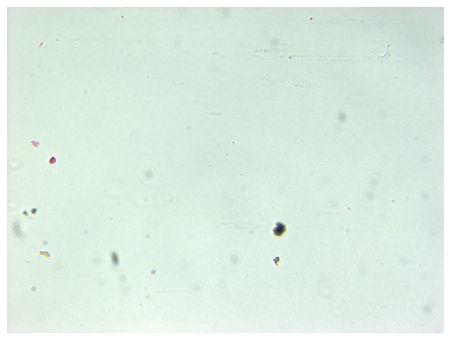

In [66]:
start = time.time()
returns = whole_slide_scan_debug(config, core=core, save_path=save_path, acq_name=acq_name_4x, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=True, focus_dive=True)
end = time.time()
print(end - start)
Audio('C:/Windows/Media/Windows Notify Calendar.wav', autoplay=True)

In [63]:
def distance(pos, support_points):
    pos = np.array(pos)
    support_points = np.array(support_points)
    distances = np.sqrt((pos - support_points)[:, 0]**2 + (pos - support_points)[:, 1]**2)
    idx = np.argmin(distances, axis=0)
    print(distances)
    print(support_points)
    return idx, distances[idx]

def whole_slide_scan_debug(config, core=None, save_path=None, acq_name=None, position_list=None, mag='4x', mda=False, z_stack=False, z_center=None, 
                     sample_depth=20, z_step=4, estimate_background=False, background_image=None, focus_dive=False):
    if mda == True:
        if position_list.shape[1] == 3:
            if z_stack:
                with Acquisition(save_path, acq_name, lsm_process_fn(config)) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3), z_start=-int(sample_depth/2), z_end=int(sample_depth/2), z_step=z_step)
                    acq.acquire(events)      
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xyz_positions=position_list.reshape(-1, 3))
                    acq.acquire(events)
        else:
            if z_center is None:
                z_center = config["Z-stage-laser"]
            if z_stack:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2), z_start=-int(sample_depth/2) + z_center, z_end=int(sample_depth/2) + z_center, z_step=z_step)
                    acq.acquire(events)
            else:
                with Acquisition(save_path, acq_name) as acq:
                    events = multi_d_acquisition_events(xy_positions=position_list.reshape(-1, 2))
                    acq.acquire(events)
    else:
        fig = plt.figure(figsize=(8, 6))
        plt.axis("off")
        show = plt.imshow(np.zeros((config["camera-resolution"][1], config["camera-resolution"][0])))
        acq_id = len(glob.glob(os.path.join(save_path, acq_name+"*")))
        acq_path = os.path.join(save_path, acq_name+"_{}".format(acq_id+1))
        os.makedirs(acq_path, exist_ok=True)
        bg_flag = False
        if estimate_background:
            sum_img = np.zeros((config["camera-resolution"][1], config["camera-resolution"][0], 3))
            sum_count = 0
        if background_image is not None:
            bg_img = white_balance(copy.deepcopy(background_image), copy.deepcopy(background_image))
            
        if mag == '4x':
            pos_z = config["Z-stage-4x"]
        elif mag == '20x':
            pos_z = config["Z-stage-20x"] 
        support_points = [(99999999, 99999999)] # dummy support point
        support_focus = [pos_z]
            
        if position_list.shape[1] == 2:
            tile_count = 0
            core.set_focus_device(config["focus-device"])
            z_positions=np.ones(position_list.shape[0]) * core.get_position()
            autofocus_count = 0
            for pos in range(position_list.shape[0]):
                x_pos = position_list[pos, 0]
                y_pos = position_list[pos, 1]
                if ( x_pos < config["hard-limit-x"][0] or x_pos > config["hard-limit-x"][1]
                    or y_pos < config["hard-limit-y"][0] or y_pos > config["hard-limit-y"][1]):
                    print('position out of range')
                    break
                    
                xy_device = core.get_xy_stage_device()
                z_device = core.get_focus_device()
                core.set_xy_position(x_pos, y_pos)
                core.wait_for_device(xy_device)
                
                    
                if focus_dive and mag=='4x':
                    support_distance = config["pixel-size-bf-4x"] * config["camera-resolution"][1] * config["autofocus-speed"]
                    idx, min_distance = distance((x_pos, y_pos), support_points)
                    if min_distance <= support_distance:
                        pos_z = support_focus[idx]
                        if pos_z < config["hard-limit-z"][0] or pos_z > config["hard-limit-z"][1]:
                            print('position out of range')
                            break
                        core.set_position(pos_z)
                        core.wait_for_device(z_device)
                        pixels = snap_image(core, rgb=True, flip_channel=True)
                        bg_flag = is_background(pixels)
                    else:
                        pos_z, pixels, bg_flag = autofocus(config, core, mag='4x', rgb=True, search_range=100, steps=3, snap=True) # snap at top but return center z
                        if not bg_flag:
                            support_points.append((x_pos, y_pos))
                            support_focus.append(pos_z)
                    z_positions[pos] = pos_z   
                pixels = img_as_float(pixels)                   
                
                if estimate_background:
                    if focus_dive:
                        bg_flag = bg_flag
                    else:
                        bg_flag = is_background(pixels)
                        print('hard check')
                    if bg_flag:
                        print(' (background tile)')
                        redive_flag=True
                        sum_img = sum_img + pixels
                        sum_count = sum_count + 1
                    else:
                        redive_flag=False                
                if background_image is not None:
                    pixels = white_balance(config, pixels, background_image)
                    pixels = flat_field(pixels, bg_img)
                show.set_data(pixels)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                io.imsave(acq_path+'/{}-{}.tiff'.format(pos, bg_flag), img_as_ubyte(pixels))
                tile_count = tile_count + 1
                sys.stdout.write('\r {}/{} tiles done'.format(tile_count, position_list.shape[0]))
        returns = []
        if estimate_background:
            returns.append((sum_img / sum_count))
            io.imsave(acq_path+'/bg_img.tiff', img_as_ubyte(np.squeeze(sum_img / sum_count)))
        if focus_dive:
            z_positions = z_positions.reshape(position_list.shape[0], 1)
            returns.append(z_positions)
        return tuple(returns)

 Processing tiles: 272/272
 stitching, please wait...

[java.lang.Enum.toString] [ERROR] Malfunctioning plugin: net.imagej.legacy.convert.DoubleToImagePlusConverter
java.lang.ExceptionInInitializerError
	at net.imagej.legacy.LegacyService.getImageMap(LegacyService.java:259)
	at net.imagej.legacy.convert.AbstractLegacyConverter.legacyEnabled(AbstractLegacyConverter.java:58)
	at net.imagej.legacy.convert.AbstractLegacyConverter.canConvert(AbstractLegacyConverter.java:50)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:155)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:94)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:86)
	at org.scijava.convert.AbstractConverter.supports(AbstractConverter.java:141)
	at org.scijava.convert.AbstractConverter.supports(AbstractConverter.java:66)
	at org.scijava.plugin.HandlerService.getHandler(HandlerService.java:58)
	at org.scijava.util.ConversionUtils.handler(ConversionUtils.java:219)
	at org.scijava.util.ConversionUtils.co

 Diving focus at -1Score: 0.07400820595929965, Position 3453.9633333333336
 Diving focus at 0Score: 0.07429589171338724, Position 3470.63


KeyboardInterrupt: 

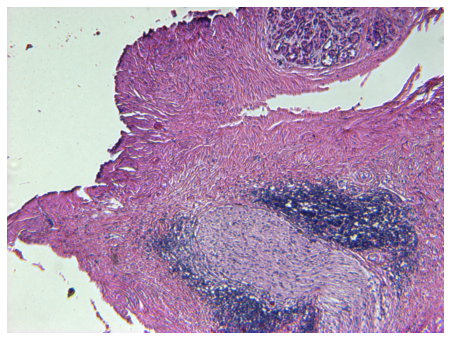

In [83]:
returns = whole_slide_scan(config, core=core, save_path=save_path, acq_name=acq_name_4x, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), mda=False, estimate_background=True, focus_dive=True)
#bg_image = io.imread('data/acquisition/PDAC_MetroHealth_205-4x-bf_2/bg_img.tiff')
Audio('C:/Windows/Media/Windows Notify Calendar.wav', autoplay=True)


In [74]:
def stitching_export(config, ij, save_path, acq_name, mda, position_list, flip_y, correction, background_image, mag):
    stitching(config=config, ij=ij, save_path=save_path, acq_name=acq_name, mda=mda, position_list=position_list, flip_y=flip_y, correction=correction, background_image=background_image)
    export_slide(mag=mag)
    pd_arr = pd.DataFrame(returns[1])
    pd_arr.to_csv(os.path.join(save_path, acq_name_4x+'-z_pos.csv'), index=False)
    pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name_4x+'-z_pos.csv'))
    z_pos_4x = np.array(pd_arr_r)
    print('\r, 4x brighfield acquisition done!')
    Audio('C:/Windows/Media/Windows Proximity Notification.wav', autoplay=True)
stitching_thread = threading.Thread(target=stitching_export, args=(config, ij, save_path, acq_name_4x, False, position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), True, True, returns[0], '4x'))
stitching_thread.start()

 Processing tiles: 272/272
 stitching, please wait...

[java.lang.Enum.toString] [ERROR] Malfunctioning plugin: net.imagej.legacy.convert.DoubleToImagePlusConverter
java.lang.NoClassDefFoundError: Could not initialize class net.imagej.legacy.LegacyImageMap
	at net.imagej.legacy.LegacyService.getImageMap(LegacyService.java:259)
	at net.imagej.legacy.convert.AbstractLegacyConverter.legacyEnabled(AbstractLegacyConverter.java:58)
	at net.imagej.legacy.convert.AbstractLegacyConverter.canConvert(AbstractLegacyConverter.java:50)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:155)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:94)
	at org.scijava.convert.AbstractConverter.canConvert(AbstractConverter.java:86)
	at org.scijava.convert.AbstractConverter.supports(AbstractConverter.java:141)
	at org.scijava.convert.AbstractConverter.supports(AbstractConverter.java:66)
	at org.scijava.plugin.HandlerService.getHandler(HandlerService.java:58)
	at org.scijava.convert.AbstractConvertService.getHandle

exporting slides, please wait...
, 4x brighfield acquisition done!


In [ ]:
# stitching(config, ij, save_path=save_path, acq_name=acq_name_4x, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=True, background_image=returns[0])
# #stitching(config, ij, save_path=save_path, acq_name=acq_name_4x, mda=False, position_list=position_list.reshape(position_list.shape[0]*position_list.shape[1], -1), flip_y=True, correction=True, background_image=bg_image)
# export_slide(mag='4x')
# pd_arr = pd.DataFrame(returns[1])
# pd_arr.to_csv(os.path.join(save_path, acq_name_4x+'-z_pos.csv'), index=False)
# pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name_4x+'-z_pos.csv'))
# z_pos_4x = np.array(pd_arr_r)
# print('\r, 4x brighfield acquisition done!')
# Audio('C:/Windows/Media/Windows Proximity Notification.wav', autoplay=True)

## 6. Use machine learning detection
Run the below section. Wait for the detection map to be printed.

In [ ]:
### Machine learning detection model
predictor = config["predictor"]
os.makedirs('data-predictor', exist_ok=True)
shutil.copyfile(os.path.join('data', 'slides', '4x', acq_name_4x+'.ome.tif'), os.path.join('data-predictor', acq_name_4x+'.ome.tif'))
subprocess.run(["python", "patch_extraction.py", "-s", config["slide-type"], "-f", "tif", "-p", "1"], shell=True)
slides = glob.glob(os.path.join('data-predictor', '*.tif')) + glob.glob(os.path.join('data-predictor', '*.jpg'))
pos = []
image_format = slides[0].split('.')[-1]
for slide in slides:
    slide_name = slide.split(os.sep)[-1].replace('.'+image_format, '')
    fields = glob.glob(os.path.join('data-predictor', slide_name, '*.tif'))
    if config["classifier"] == "Supervised":
        for field in fields:
            pos_x = int(field.split('x=')[1].split(',')[0])
            pos_y = int(field.split('y=')[1].split(',')[0])
            img = io.imread(field)
            prediction = predictor.compute(img)
            c = np.argmax(prediction)
            pos.append([int(pos_x/224), int(pos_y/224), c])
    if config["classifier"] == "MIL":
        prediction_bag, prediction_patch = predictor.compute(fields)
        if prediction_bag:
            for i in range(len(fields)):
                pos_x = int(fields[i].split('x=')[1].split(',')[0])
                pos_y = int(fields[i].split('y=')[1].split(',')[0])
                pos.append([int(pos_x/224), int(pos_y/224), prediction_patch[i]])
pos_arr = np.vstack(pos)
w = np.max(pos_arr, 0)[0]+1
h = np.max(pos_arr, 0)[1]+1
cmap = np.zeros((h ,w))
for p in pos:
    cmap[p[1], p[0]] = p[2]
if config["slide-type"] == "slide":
    cmap_p = morphology.remove_small_objects(img_as_bool(cmap), min_size=6)
    cmap_p = morphology.remove_small_holes(cmap_p, area_threshold=8)
if config["slide-type"] == "TMA":
    cmap_p = cmap
plt.imshow(cmap_p)
os.makedirs(os.path.join('qupath-projects', 'predictions'), exist_ok=True)
io.imsave(os.path.join('qupath-projects', 'predictions', slide_name+'-cmap.bmp'), img_as_ubyte(cmap_p))
# resample 20x bf
field_4x = 224 * config["pixel-size-bf-4x"]
field_w_20x = config["camera-resolution"][0] * config["pixel-size-bf-20x"] * 0.9
field_h_20x = config["camera-resolution"][1] * config["pixel-size-bf-20x"] * 0.9
rw = int(w * (field_4x/field_w_20x))
rh = int(h * (field_4x/field_h_20x))
cmap_r = transform.resize(cmap_p, (rh, rw), order=1, mode='symmetric')
thresh = threshold_mean(cmap_r)*0.5
cmap_r = cmap_r >= thresh
ps_pos = np.where(cmap_r==1)
pos_20x_df = pd.DataFrame({
    'x_pos' : ps_pos[1]*field_w_20x/config["pixel-size-bf-4x"],
    'y_pos' : ps_pos[0]*field_h_20x/config["pixel-size-bf-4x"]}
)
# resample shg
field_mp = 256 * config["pixel-size-shg-base"] * 0.9
rw = int(w * (field_4x/field_mp))
rh = int(h * (field_4x/field_mp))
cmap_r = transform.resize(cmap_p, (rh, rw), order=1, mode='symmetric')
thresh = threshold_mean(cmap_r)*0.5
cmap_r = cmap_r >= thresh
ps_pos = np.where(cmap_r==1)
pos_mp_df = pd.DataFrame({
    'x_pos' : ps_pos[1]*field_mp/config["pixel-size-bf-4x"],
    'y_pos' : ps_pos[0]*field_mp/config["pixel-size-bf-4x"]}
)
if image_format == 'tif':
    pos_mp_df.to_csv(os.path.join('qupath-projects', 'predictions', 'mp-'+slide_name+'.tif.csv'), index=False)
    pos_mp_df.to_csv(os.path.join('qupath-projects', 'mp-tiles', slide_name+'.tif.csv'), index=False)
    pos_20x_df.to_csv(os.path.join('qupath-projects', 'predictions', '20x-'+slide_name+'.tif.csv'), index=False)
    pos_20x_df.to_csv(os.path.join('qupath-projects', '20x-tiles', slide_name+'.tif.csv'), index=False)
if image_format == 'jpg':
    pos_mp_df.to_csv(os.path.join('qupath-projects', 'predictions', 'mp-'+slide_name+'.csv'), index=False)
    pos_mp_df.to_csv(os.path.join('qupath-projects', 'mp-tiles', slide_name+'.csv'), index=False)
    pos_20x_df.to_csv(os.path.join('qupath-projects', 'predictions', '20x-'+slide_name+'.csv'), index=False)
    pos_20x_df.to_csv(os.path.join('qupath-projects', '20x-tiles', slide_name+'.csv'), index=False)

## 7. Brighfield acquisition at 20x
Make sure 20x brightfield annotation files are generated appropriately. Run the below section. Wait for the "20x brighfield acquisition done!" message.

In [9]:
acq_name_20x = '-20x-'
### enter the acquisition name appended to the

 Processing tiles: 40/40
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_205-20x--Object\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (123 ms)[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_205-20x--Object\1.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] 1392x1040px, channels=3, timepoints=1 (157 ms)[java.lang.Enum.toString] 
[java.

exporting slides, please wait...
Object: 2/2
, 20x brighfield acquisition done!


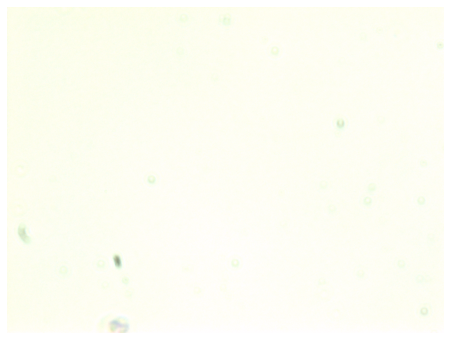

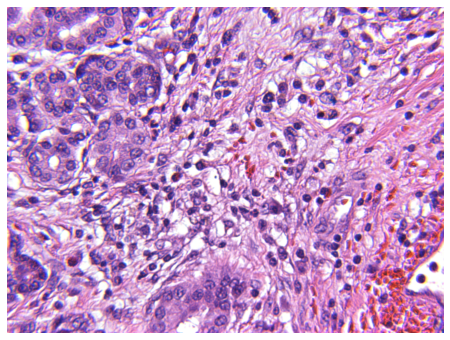

In [15]:
# batch 20x acquisition
switch_objective(config, core, '20x')
switch_mod(config, core, 'bf')
slide_name = acq_name
pd_arr_r = pd.read_csv(os.path.join(save_path, acq_name_4x+'-z_pos.csv'))
z_pos_4x = np.array(pd_arr_r)
position_list_z = z_pos_4x
position_list = generate_grid(config, mag='4x')
position_list_xyz = np.concatenate((position_list, position_list_z.reshape((position_list.shape[0], position_list.shape[1], 1))), 2)
position_lists_20x, annotation_names = annotations_positionlist(config, image_name=acq_name_4x, out_mag='20x')
return_20x_list = []
for idx, roi in enumerate(position_lists_20x):
    current_acq_name = slide_name + acq_name_20x + annotation_names[idx]
    sampled_pos_xyz = resample_z_pos(config, mag='20x', xy_pos=roi, xyz_pos_list_4x=position_list_xyz)
    if idx==0:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=current_acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=True, focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=current_acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=True, background_image=returns_20x[0])
        bg_img = returns_20x[0]
    else:
        returns_20x = whole_slide_scan(config, core=core, save_path=save_path, acq_name=current_acq_name, mag='20x', position_list=sampled_pos_xyz, mda=False, estimate_background=False, background_image=bg_img, focus_dive=True)
        stitching(config, ij, save_path=save_path, acq_name=current_acq_name, mag='20x', mda=False, position_list=sampled_pos_xyz, flip_y=True, correction=False)
    export_slide(mag='20x', remove_file=True)
    return_20x_list.append(returns_20x[-1]) ### store focus map
    np.save(os.path.join(save_path, slide_name +'-20x'+'-z_pos.npy'), return_20x_list, allow_pickle=True)
    print('Object: {}/{}'.format(idx+1, len(position_lists_20x)))
print('\r, 20x brighfield acquisition done!')

## 8. SHG acquisition at 20x
Make sure SHG annotation files are generated appropriately. Run the below section. Wait for the "20x brighfield acquisition done!" message.

In [16]:
acq_name_lsm = '-lsm-'

In [21]:
# batch shg acquisition use all map
acq_name_4x = acq_name + '-4x-bf'
switch_objective(config, core, '20x')
switch_mod(config, core, 'shg')
save_path = 'data/acquisition'
slide_name = acq_name
position_lists_mp, annotation_mp = annotations_positionlist(config, image_name=acq_name_4x, out_mag='mp')
position_lists_20x, annotation_names = annotations_positionlist(config, image_name=acq_name_4x, out_mag='20x')
return_20x_list = np.load(os.path.join(save_path, slide_name+'-20x'+'-z_pos.npy'), allow_pickle=True).tolist()
return_20x_list = np.vstack(return_20x_list)
position_lists_20x =  np.vstack(position_lists_20x)
map_xyz_20x = np.concatenate((position_lists_20x[:, :], return_20x_list.reshape((return_20x_list.shape[0], 1))), 1)
for idx, roi in enumerate(position_lists_mp):
    current_acq_name = slide_name + acq_name_lsm + annotation_mp[idx]
    sampled_pos_xyz_mp = resample_z_pos(config, mag='mp', xy_pos=roi, xyz_pos_list_20x=map_xyz_20x)
    whole_slide_scan(config, core=core, save_path=save_path, acq_name=current_acq_name, position_list=sampled_pos_xyz_mp, mda=True, z_stack=True, sample_depth=24, z_step=6, estimate_background=False, focus_dive=False)
    stitching(config, ij, save_path=save_path, acq_name=current_acq_name, mag='mp', mda=True, z_stack=True, position_list=sampled_pos_xyz_mp, flip_y=False, rotate=270, correction=None)
    export_slide(mag='mp')
print('\r, SHG acquisition done!')

Imaging mode set as SHG
Dataset opened                 
 Processing tiles: 155/155
 stitching, please wait...

[java.lang.Enum.toString] Stitching internal version: 1.2[java.lang.Enum.toString] 
[java.lang.Enum.toString] Loading: F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_205-lsm--Object\0.tiff ... [java.lang.Enum.toString] 
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] TiffDelegateReader initializing F:\Documents\slide-scanner\smart-wsi-scanner\data\stitching\tiles\PDAC_MetroHealth_205-lsm--Object\0.tiff
[java.lang.Enum.toString] Reading IFDs
[java.lang.Enum.toString] Populating metadata
[java.lang.Enum.toString] Checking comment style
[java.lang.Enum.toString] Populating OME metadata
[java.lang.Enum.toString] dimension order is not certain, assuming XYZ instead of XYT[java.lang.Enum.toString] 
[java.lang.Enum.toString] 256x256x5px, channels=1, timepoints=1 (229 ms)[java.lang.Enum.toString] 
[

exporting slides, please wait...
, SHG acquisition done!


In [19]:
position_lists_mp, annotation_mp = annotations_positionlist(config, image_name=acq_name_4x, out_mag='mp')

In [21]:
map_xyz_20x

array([[ 7537.045    ,  5250.94     , -6963.46     ],
       [ 7537.045    ,  5468.2666225, -6964.21     ],
       [ 7537.045    ,  5685.593245 , -6962.63     ],
       ...,
       [10196.2806025, 12422.7185425, -6810.61     ],
       [10196.2806025, 12640.045165 , -6806.19     ],
       [10196.2806025, 12857.3717875, -6811.05     ]])

# 9. Close imagej

In [72]:
ij.dispose()

In [5]:
img_coords = (4080, 1060)
stage_coords = (8000+1.105*(img_coords[0]*(-6.22)+27764), -3000+1.105*(img_coords[1]*(-6.22)+21357))

In [5]:
def img_stage(img_coords):
    '''image coordinates from prescan image'''
    stage_coords = (8000+1.105*(img_coords[0]*(-6.22)+27764), -3000+1.105*(img_coords[1]*(-6.22)+21357))
    return stage_coords

In [7]:
img_stage((3540, 250))

(14348.446, 18881.21)

In [9]:
img_stage((4800,2750))

(13936.06, -19.815000000000055)

In [73]:
ij = imagej.init('fiji\\fiji\\Fiji.app')